In [1]:
%load_ext autoreload

%autoreload 2

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [27]:
import os
import glob
import pickle

from spectral.io import envi
import spectral

from skimage.io import imsave

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
labels = pd.read_excel("/mnt/c/Users/Conor/Google Drive/PhD/Project with Janet/ECS_Labels.xlsx")

In [20]:
drop_columns = ["score", "score.1", "score.2", "Unnamed: 12"]

labels = pd.read_excel("/mnt/c/Users/Conor/Google Drive/PhD/Project with Janet/Scoring grids Advancing Front (TMAs 1-3).xlsx", sheet_name = "reformatted", header = 0)#.drop(drop_columns, axis = 1)

In [21]:
labels.columns = ['TMA', 'Core', 'gender', 'Patient', 'Site',
       'Pathogical', 'T', 'N', 'ECS', 'diff',
       'advancing front type', 'Death', 'survival',
       'recurrence', 'radiotherapy', 'Age']

In [22]:
labels = labels.dropna(subset = ["TMA", "Core"], axis = 0)

In [10]:
labels.tail()

,TMA,Core,gender,Patient,Site,Pathogical,T,N,ECS,diff,advancing front type,Death,survival,recurrence,radiotherapy,Age
331,3.0,H5,f,3647 (Liv7),oral tongue,pT3N2bM0,3,2b,yes,mod,non-cohesive,yes,6.0,NaN,yes,60.0
332,3.0,H4,m,3773 (Liv47),other,pT2N2b,2,2b,no,mod,non-cohesive,NaN,NaN,NaN,NaN,53.0
333,3.0,H3,f,3706 (Liv22),oral tongue,pT3N0,3,0,no,mod,non-cohesive,NaN,NaN,NaN,NaN,64.0
334,3.0,H2,m,3763 (Liv37),FOM,pT3N2bM0,3,2b,yes,mod,dyscohesive,NaN,NaN,NaN,NaN,57.0
335,3.0,H1,m,3744 (Liv34),FOM,pT2N1,2,1,no,mod,dyscohesive,NaN,NaN,NaN,NaN,65.0


In [11]:
labels.TMA.value_counts()

2.0    112
1.0    112
3.0    110
Name: TMA, dtype: int64

In [17]:
labels = labels.drop_duplicates().set_index(["TMA", "Core"])

In [24]:
labels.head()

,TMA,Core,gender,Patient,Site,Pathogical,T,N,ECS,diff,advancing front type,Death,survival,recurrence,radiotherapy,Age
0,1.0,G6,m,3143,FOM,pT4N0,4,0,no,mod,islands,yes,111.0,yes,yes,58.0
1,1.0,H5,m,3167,oral tongue,T2N2Mx,2,2,yes,mod,non-cohesive,yes,13.0,yes(05),yes,74.0
2,1.0,C10,m,3169,FOM,pT3N1M0,3,1,no,poor,non cohesive,yes,17.0,NaN,yes,63.0
3,1.0,H4,m,3170,other,pT4N2b,4,2b,yes,NaN,NaN,yes,121.0,no,yes,59.0
4,1.0,D2,m,3230,oral tongue,pT2N1Mx,2,1,yes,well,non-cohesive,yes,6.0,yes,yes,74.0


In [30]:
labels

,TMA,Core,gender,Patient,Site,Pathogical,T,N,ECS,diff,advancing front type,Death,survival,recurrence,radiotherapy,Age
0,1.0,G6,m,3143,FOM,pT4N0,4,0,no,mod,islands,yes,111.0,yes,yes,58.0
1,1.0,H5,m,3167,oral tongue,T2N2Mx,2,2,yes,mod,non-cohesive,yes,13.0,yes(05),yes,74.0
2,1.0,C10,m,3169,FOM,pT3N1M0,3,1,no,poor,non cohesive,yes,17.0,NaN,yes,63.0
3,1.0,H4,m,3170,other,pT4N2b,4,2b,yes,NaN,NaN,yes,121.0,no,yes,59.0
4,1.0,D2,m,3230,oral tongue,pT2N1Mx,2,1,yes,well,non-cohesive,yes,6.0,yes,yes,74.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,3.0,H5,f,3647 (Liv7),oral tongue,pT3N2bM0,3,2b,yes,mod,non-cohesive,yes,6.0,NaN,yes,60.0
332,3.0,H4,m,3773 (Liv47),other,pT2N2b,2,2b,no,mod,non-cohesive,NaN,NaN,NaN,NaN,53.0
333,3.0,H3,f,3706 (Liv22),oral tongue,pT3N0,3,0,no,mod,non-cohesive,NaN,NaN,NaN,NaN,64.0
334,3.0,H2,m,3763 (Liv37),FOM,pT3N2bM0,3,2b,yes,mod,dyscohesive,NaN,NaN,NaN,NaN,57.0


In [31]:
file_name

'/mnt/h/FTIR_Data/numpy_format/TMA_2/TMA_2.1_A1.hdr'

In [56]:
for file_name in tqdm(glob.glob("/mnt/h/FTIR_Data/numpy_format/**/*.hdr")):
    
    name = file_name.split("/")[-1][:-4]
    tma = file_name.split("/")[-2]
    
    
    print(name, tma)

    file = envi.open(file_name)
    
    wn = np.array(file.metadata["wn"], dtype = np.int)
    i = np.argmin(np.abs(1652 - wn))

    im = file.load()
    
    file_place = f"/mnt/c/Users/Conor/Google Drive/PhD/Project with Janet/Label_Images/{tma}/Blank"
    
    if not os.path.exists(file_place):
        
        os.mkdir(file_place)
    
    imsave(os.path.join(file_place, f"{name}.png"), im[:,:,i])

11225_2_A ECS
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


11225_4_A ECS
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [0.10095863789319992, 1.008103847503662]. Convert image to uint8 prior to saving to suppress this warning.


11288_2_A ECS
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.15763331949710846, 0.7863308191299438]. Convert image to uint8 prior to saving to suppress this warning.


14288_2_A ECS
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.1342272162437439, 1.134209156036377]. Convert image to uint8 prior to saving to suppress this warning.


14347_3_A ECS
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.14375850558280945, 1.3799184560775757]. Convert image to uint8 prior to saving to suppress this warning.


14364_2_A ECS
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.025013938546180725, 1.3303425312042236]. Convert image to uint8 prior to saving to suppress this warning.


14364_2_A_old ECS
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [0.016162356361746788, 1.0229301452636719]. Convert image to uint8 prior to saving to suppress this warning.


14364_2_B ECS
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.019895542412996292, 1.4240736961364746]. Convert image to uint8 prior to saving to suppress this warning.


14364_3_A ECS
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [0.07205430418252945, 1.213991641998291]. Convert image to uint8 prior to saving to suppress this warning.


14365_2_A ECS
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.02328215353190899, 0.8178361058235168]. Convert image to uint8 prior to saving to suppress this warning.


14365_3_A ECS
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [0.10019680857658386, 1.3657920360565186]. Convert image to uint8 prior to saving to suppress this warning.


14365_3_B ECS
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [0.09657692164182663, 1.1343942880630493]. Convert image to uint8 prior to saving to suppress this warning.


14374_2_A ECS
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.19395233690738678, 1.687588095664978]. Convert image to uint8 prior to saving to suppress this warning.


14374_2_B ECS
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [0.009487279690802097, 1.776719570159912]. Convert image to uint8 prior to saving to suppress this warning.


14374_3_A ECS
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


14443_2_A ECS
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.027368949726223946, 1.088370442390442]. Convert image to uint8 prior to saving to suppress this warning.


14443_3_A ECS
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.10290532559156418, 8.0]. Convert image to uint8 prior to saving to suppress this warning.


12127_2a Other
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.0898437350988388, 1.3123581409454346]. Convert image to uint8 prior to saving to suppress this warning.


12148_2a Other
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.027043841779232025, 1.0125054121017456]. Convert image to uint8 prior to saving to suppress this warning.


12148_2b Other
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.042486000806093216, 0.5426416397094727]. Convert image to uint8 prior to saving to suppress this warning.


12148_3a Other
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.022395260632038116, 0.9491646885871887]. Convert image to uint8 prior to saving to suppress this warning.


12148_3b Other
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.02511044405400753, 1.0272948741912842]. Convert image to uint8 prior to saving to suppress this warning.


12201_3a Other
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.039080116897821426, 1.0165302753448486]. Convert image to uint8 prior to saving to suppress this warning.


12201_3c Other
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.008416385389864445, 1.424281120300293]. Convert image to uint8 prior to saving to suppress this warning.


12202_3a Other
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.28500622510910034, 0.7970008254051208]. Convert image to uint8 prior to saving to suppress this warning.


12262_2a Other
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.015398976393043995, 1.0219032764434814]. Convert image to uint8 prior to saving to suppress this warning.


12262_3a_2 Other
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.02087191864848137, 0.8373304009437561]. Convert image to uint8 prior to saving to suppress this warning.


12262_3b Other
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.025517510250210762, 1.0845869779586792]. Convert image to uint8 prior to saving to suppress this warning.


12265_2a Other
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.20020605623722076, 0.9869154095649719]. Convert image to uint8 prior to saving to suppress this warning.


12265_2b_scan Other
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.030269090086221695, 1.0136239528656006]. Convert image to uint8 prior to saving to suppress this warning.


14347_2_A Other
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [0.265080988407135, 1.6480611562728882]. Convert image to uint8 prior to saving to suppress this warning.


474 Other
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.17947405576705933, 2.092845916748047]. Convert image to uint8 prior to saving to suppress this warning.


D23580 Other
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.22861984372138977, 2.2189815044403076]. Convert image to uint8 prior to saving to suppress this warning.


K15 Other
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.03451749309897423, 1.777080774307251]. Convert image to uint8 prior to saving to suppress this warning.


scan1 Other
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.01833500526845455, 1.7026454210281372]. Convert image to uint8 prior to saving to suppress this warning.


scans Other
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.06471284478902817, 0.9449443221092224]. Convert image to uint8 prior to saving to suppress this warning.


test Other
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.09768129885196686, 0.923211932182312]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_A5 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.09454146027565002, 0.8049359917640686]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_A6 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.23818473517894745, 0.8861128687858582]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_A7 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.32443946599960327, 0.46164336800575256]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_B7 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.3310006856918335, 0.6259439587593079]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_C2 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.21574129164218903, 0.5942030549049377]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_C3 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.2131195068359375, 1.0771304368972778]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_C4 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.3451411724090576, 0.7428249716758728]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_C5 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.34548452496528625, 0.40943461656570435]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_C6 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.3316204249858856, 0.5339117646217346]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_C7 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.3195768892765045, 1.018625259399414]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_D3 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.2150927633047104, 0.9372139573097229]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_D4 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.20954222977161407, 0.9924736618995667]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_D5 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.16419744491577148, 0.5447947382926941]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_D6 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.18390780687332153, 0.8899133801460266]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_A10 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.1603328138589859, 0.5917069911956787]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_A11 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.06048225983977318, 1.0502123832702637]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_A12 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.06625114381313324, 0.8660063147544861]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_A14 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.08834782987833023, 0.6817240715026855]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_A8 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.1297910213470459, 1.0725127458572388]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_A9 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.15516069531440735, 0.571195662021637]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_B10 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.07277581095695496, 1.2680519819259644]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_B14 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.07625869661569595, 0.9703983068466187]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_C10 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.09132196754217148, 0.9120227098464966]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_C11 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.06401202827692032, 0.6690508127212524]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_C12 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.07613449543714523, 0.5821682214736938]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_C14 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.07230687886476517, 0.7476693987846375]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_C8 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.0637236163020134, 0.8830487728118896]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_C9 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.058239132165908813, 1.5028818845748901]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_D10 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.07572261989116669, 0.7770345211029053]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_D11 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.07092376053333282, 0.8144883513450623]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_D12 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.07460793107748032, 0.6864698529243469]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_D14 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.08227314054965973, 0.5643237829208374]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_D8 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.0626990795135498, 0.906590461730957]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_D9 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.07605195790529251, 0.7856103181838989]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.3_E2 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.10163553059101105, 0.754407525062561]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.3_E4 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.06620724499225616, 0.9381502270698547]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.3_F4 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.061969105154275894, 0.6799298524856567]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.3_F5 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.044260602444410324, 0.6595959663391113]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.3_F6 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.03402409702539444, 0.7174436450004578]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.3_F7 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.06534558534622192, 0.9377993941307068]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.3_G2 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.050204258412122726, 0.8682910203933716]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.3_G6 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.052220262587070465, 0.8304951786994934]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_E10 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.05327964946627617, 0.6714993715286255]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_E11 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.029685866087675095, 0.6780234575271606]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_E12 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.09518982470035553, 0.7618157267570496]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_E14 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.0032599736005067825, 1.2570445537567139]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_F10 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.05043378099799156, 0.7898394465446472]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_F11 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.03029494360089302, 0.5899457931518555]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_F12 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.0245624091476202, 0.6423383355140686]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_F13 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.1339978575706482, 0.7031323909759521]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_F14 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.13440966606140137, 0.6733386516571045]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_F8 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.05289432778954506, 0.8917608261108398]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_F9 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.04978039115667343, 0.8732233047485352]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_G13 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.10272721946239471, 0.856218159198761]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_G8 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.05279633402824402, 0.7124903798103333]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_G9 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.06061561033129692, 0.5876961350440979]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_H10 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.0239651370793581, 0.8756130933761597]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_H12 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.01743326522409916, 0.7665883302688599]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_H13 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.09460245817899704, 0.7938341498374939]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_H14 TMA_1
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.1338169425725937, 0.6203303933143616]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_A1 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.04687068238854408, 0.7137520909309387]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_A2 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.06834283471107483, 0.43744632601737976]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_B1 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.037463683634996414, 0.6877568364143372]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_B4 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.06591574102640152, 0.7328808903694153]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_B5 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.05373525619506836, 0.6743022203445435]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_B6 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.06951074302196503, 0.7288614511489868]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_B7 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.0641695111989975, 0.8933482766151428]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_C1 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.03150737285614014, 0.6890326142311096]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_C3 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.03849058970808983, 0.513815701007843]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_C4 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.03120024874806404, 0.8301900625228882]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_C5 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.02008845843374729, 1.0106303691864014]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_C6 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.03803182765841484, 0.7912313938140869]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_C7 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.014021112583577633, 1.0199569463729858]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_D2 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.03107987344264984, 0.7517107129096985]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_D3 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.025276197120547295, 0.8559257388114929]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_D4 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.028696244582533836, 0.947730302810669]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_D5 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.033625729382038116, 0.9131882786750793]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_D6 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.06868716329336166, 0.7426016926765442]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_D7 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.08464161306619644, 0.9567755460739136]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_E1 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.02147625759243965, 0.6875168085098267]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_E2 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.010743333026766777, 1.0182772874832153]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_E3 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.06534285098314285, 1.1200249195098877]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_E5 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.055942803621292114, 0.9746019840240479]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.1_E7 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.04229029268026352, 1.0301523208618164]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_A8 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.036448199301958084, 0.7368051409721375]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_B8 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.03510064631700516, 0.8135386109352112]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_C10 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.05812443047761917, 0.6506522297859192]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_C9 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.050358209758996964, 0.7615803480148315]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_D10 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.058623988181352615, 0.6775256395339966]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_D9 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.048327215015888214, 0.9322748184204102]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_E8 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.04470043256878853, 0.7256902456283569]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.2_E9 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.03781238943338394, 0.8486539125442505]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.3_F1 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.04879022389650345, 0.8973382711410522]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.3_F2 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.05765338987112045, 0.9833279252052307]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.3_F3 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.0342499315738678, 0.6114583611488342]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.3_G2 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.045689575374126434, 0.7224456667900085]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.3_G3 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.0375555120408535, 0.7333164215087891]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.3_G4 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.03663858026266098, 0.9747340083122253]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.3_H1 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.048804860562086105, 0.7172216773033142]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.3_H2 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.03814498335123062, 0.9769144654273987]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.3_I1 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.04296545684337616, 0.43691909313201904]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.3_I2 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.044567544013261795, 0.8362464904785156]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_F10 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.08033731579780579, 0.7839770317077637]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_F12 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.08266885578632355, 0.7839885354042053]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_F13 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.0925050601363182, 0.6197843551635742]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_F14 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.10190670937299728, 0.583433210849762]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_F8 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.010666669346392155, 1.2784135341644287]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_F9 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.04693117365241051, 1.0610734224319458]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_G10 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.08529260009527206, 0.8251736164093018]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_G11 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.08076652139425278, 0.929340124130249]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_G12 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.10401546955108643, 0.7665184736251831]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_G13 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.10051978379487991, 0.722444474697113]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_G8 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.04520661383867264, 0.9769211411476135]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_G9 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.061381369829177856, 0.8787484169006348]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_H11 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.109468013048172, 0.8336614966392517]. Convert image to uint8 prior to saving to suppress this warning.


TMA_1.4_H9 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.07179214805364609, 1.0313042402267456]. Convert image to uint8 prior to saving to suppress this warning.


TMA_2.1_A1 TMA_2
Header parameter names converted to lower case.


Lossy conversion from float32 to uint8. Range [-0.04687068238854408, 0.7137520909309387]. Convert image to uint8 prior to saving to suppress this warning.


In [40]:
np.argmin(abs(1652 - np.array(file.metadata["wn"], dtype = np.int)))

195

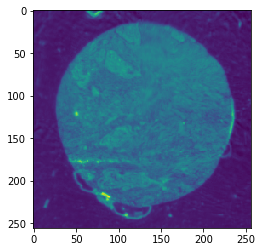

In [29]:
plt.imshow(im[:,:,195].squeeze())

In [368]:
total = pd.DataFrame()

for file_name in tqdm(glob.glob("/mnt/h/FTIR_Data/numpy_format/TMA_1/*.hdr")):
    
    #if "D5" not in file_name: continue
        
    name = file_name.split("_")[-1][:-4]
    
    #print(name)
        
    try:
        
        annotation = skimage.io.imread(f"/mnt/h/FTIR_Data/Label_Images/Janet/{name}.png")
        mask = np.all(annotation == [255,127,39,255], axis = 2)
        
    except:
        continue
        
    #print(annotation.shape)
    
    datacube = envi.open(file_name)
    
    im = datacube.load()
    df = pd.DataFrame(im[mask, : ])
    
    df["Core"] = name
    df = df.merge(labels)
    df = df.set_index(["Core", "ECS"])
    df.columns = np.array(datacube.metadata["wn"], dtype = np.int)
    
    total = total.append(df)

Header parameter names converted to lower case.
Header parameter names converted to lower case.
Header parameter names converted to lower case.


/home/conor/miniconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


Header parameter names converted to lower case.
Header parameter names converted to lower case.
Header parameter names converted to lower case.
Header parameter names converted to lower case.
Header parameter names converted to lower case.
Header parameter names converted to lower case.



In [369]:
total.columns

Int64Index([ 898,  902,  906,  910,  914,  917,  921,  925,  929,  933,
            ...
            3768, 3772, 3775, 3779, 3783, 3787, 3791, 3795, 3799, 3802],
           dtype='int64', length=754)

In [370]:
total.head()

898       902       906       910       914       917   \
Core ECS                                                               
C3   -    0.214312  0.191091  0.195508  0.222698  0.231200  0.222930   
     -    0.231992  0.219790  0.199261  0.206174  0.224913  0.234315   
     -    0.198140  0.202776  0.185451  0.158884  0.145301  0.154051   
     -    0.138318  0.148427  0.168654  0.161829  0.155318  0.172147   
     -    0.087075  0.094139  0.108012  0.111501  0.116876  0.133214   

              921       925       929       933   ...      3768      3772  \
Core ECS                                          ...                       
C3   -    0.211314  0.197655  0.197759  0.211244  ...  0.244157  0.242982   
     -    0.231984  0.221773  0.210387  0.204696  ...  0.259163  0.257018   
     -    0.164455  0.166549  0.165936  0.163834  ...  0.193070  0.192957   
     -    0.189362  0.194212  0.192112  0.191235  ...  0.205513  0.207530   
     -    0.140019  0.141190  0.145396  0.143244  ...  0.186457  0.186340   

              3775      3779      3783      3787      3791      3795  \
Core ECS                                                               
C3   -    0.243633  0.245073  0.246401  0.246972  0.247871  0.247577   
     -    0.255679  0.255497  0.258117  0.260129  0.259935  0.258687   
     -    0.193938  0.193731  0.193813  0.194842  0.195037  0.193313   
     -    0.209197  0.208695  0.207203  0.206663  0.207208  0.207628   
     -    0.186710  0.186410  0.185574  0.185191  0.185126  0.184274   

              3799      3802  
Core ECS                      
C3   -    0.245361  0.243958  
     -    0.256440  0.255024  
     -    0.191167  0.191225  
     -    0.207940  0.208320  
     -    0.182857  0.182712  

[5 rows x 754 columns]

/home/conor/miniconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3242: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
/home/conor/miniconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


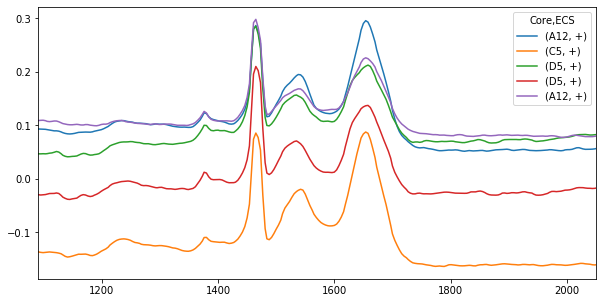

In [373]:
total.iloc[:,50:300].sample(5).T.plot(figsize = (10,5))

In [460]:
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer, normalize, robust_scale, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pipe = Pipeline([
    ("Normalise", FunctionTransformer(robust_scale, kw_args = {"axis": 1})),
    ("Scale",  StandardScaler()),
    ("PCA", PCA(n_components = 1, whiten = True)),
    ("LDA", LinearDiscriminantAnalysis(n_components = 1))
                ])

In [461]:
pcadf = pd.DataFrame(pipe.fit_transform(X = total, y = total.reset_index().ECS)
                     , index = total.index
                     , columns = ["PCA_1"])

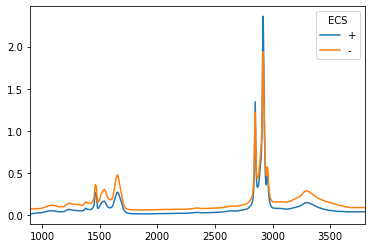

In [383]:
total.groupby(level = "ECS").mean().T.plot()

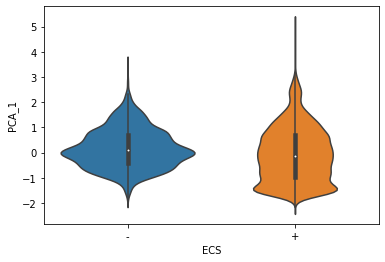

In [464]:
sns.violinplot(x = "ECS", y = "PCA_1", data = pcadf.reset_index())

In [ ]:
sns.violinplot(x = "ECS", y = "PCA_1", data = pcadf.reset_index())

In [441]:
pcadf

PCA_1
Core ECS          
C3   -    3.387556
     -    2.674968
     -    7.356002
     -    4.543110
     -    4.435629
...            ...
D9   +   -1.769074
     +   -2.843138
     +   -4.165312
     +   -2.916776
     +   -3.477142

[33243 rows x 1 columns]

In [457]:
for name, df in pcadf.groupby(level = "ECS"):
    
    print(name)
    
    print(df.reset_index().Core.value_counts())

+
A8     6303
A12    5609
D5     5224
D9     1833
C5     1517
C6     1197
A10     962
Name: Core, dtype: int64
-
C3    9839
D4     759
Name: Core, dtype: int64


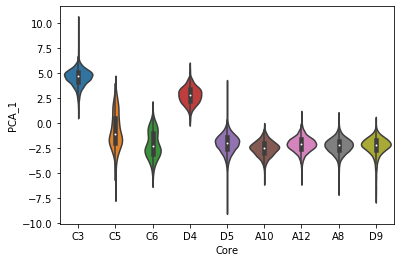

In [442]:
sns.violinplot(x = "Core", y = "PCA_1", data = pcadf.reset_index())

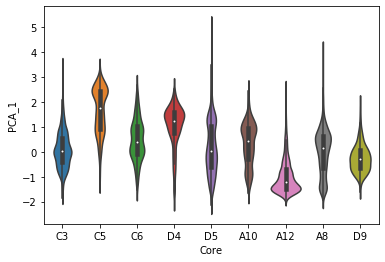

In [448]:
sns.violinplot(x = "Core", y = "PCA_1", data = pcadf.reset_index())

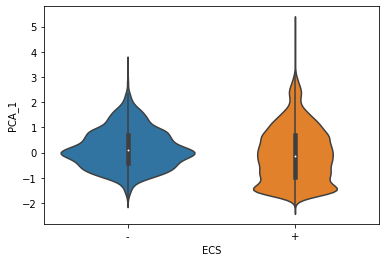

In [406]:
sns.violinplot(x = "ECS", y = "PCA_1", data = pcadf.reset_index())

In [285]:
df["PCA"] = pipe.fit_transform(df)

In [241]:
df

898       902       906       910       914       917  \
Core ECS                                                               
C3   -    0.214312  0.191091  0.195508  0.222698  0.231200  0.222930   
     -    0.231992  0.219790  0.199261  0.206174  0.224913  0.234315   
     -    0.198140  0.202776  0.185451  0.158884  0.145301  0.154051   
     -    0.138318  0.148427  0.168654  0.161829  0.155318  0.172147   
     -    0.087075  0.094139  0.108012  0.111501  0.116876  0.133214   
...            ...       ...       ...       ...       ...       ...   
D9   +    0.091681  0.089567  0.101908  0.111067  0.095253  0.081963   
     +    0.113727  0.117949  0.123123  0.113805  0.084018  0.057816   
     +    0.095951  0.097044  0.088089  0.082563  0.075474  0.065201   
     +    0.081692  0.072478  0.082772  0.099519  0.093358  0.077109   
     +    0.049121  0.037671  0.044262  0.052166  0.053024  0.055671   

               921       925       929       933  ...      3772      3775  \
Core ECS                                          ...                       
C3   -    0.211314  0.197655  0.197759  0.211244  ...  0.242982  0.243633   
     -    0.231984  0.221773  0.210387  0.204696  ...  0.257018  0.255679   
     -    0.164455  0.166549  0.165936  0.163834  ...  0.192957  0.193938   
     -    0.189362  0.194212  0.192112  0.191235  ...  0.207530  0.209197   
     -    0.140019  0.141190  0.145396  0.143244  ...  0.186340  0.186710   
...            ...       ...       ...       ...  ...       ...       ...   
D9   +    0.087309  0.089087  0.083139  0.078411  ...  0.105247  0.107069   
     +    0.066959  0.084429  0.082754  0.076709  ...  0.123739  0.124117   
     +    0.063147  0.063167  0.063177  0.065310  ...  0.103603  0.103143   
     +    0.076711  0.078603  0.076610  0.074464  ...  0.114923  0.115785   
     +    0.059071  0.058857  0.053983  0.049091  ...  0.138518  0.139365   

              3779      3783      3787      3791      3795      3799  \
Core ECS                                                               
C3   -    0.245073  0.246401  0.246972  0.247871  0.247577  0.245361   
     -    0.255497  0.258117  0.260129  0.259935  0.258687  0.256440   
     -    0.193731  0.193813  0.194842  0.195037  0.193313  0.191167   
     -    0.208695  0.207203  0.206663  0.207208  0.207628  0.207940   
     -    0.186410  0.185574  0.185191  0.185126  0.184274  0.182857   
...            ...       ...       ...       ...       ...       ...   
D9   +    0.108130  0.107293  0.106515  0.106191  0.106191  0.105780   
     +    0.125685  0.125629  0.123793  0.123279  0.124585  0.125081   
     +    0.102709  0.102732  0.103225  0.103697  0.105455  0.105813   
     +    0.115346  0.115493  0.116627  0.116754  0.115513  0.113199   
     +    0.139525  0.139209  0.138770  0.138523  0.139243  0.139000   

              3802       PCA  
Core ECS                      
C3   -    0.243958 -1.656505  
     -    0.255024 -1.993397  
     -    0.191225 -2.012943  
     -    0.208320 -1.670712  
     -    0.182712 -1.131638  
...            ...       ...  
D9   +    0.105346 -0.214964  
     +    0.125860 -0.163717  
     +    0.103932 -0.137875  
     +    0.112809 -0.173607  
     +    0.138179 -0.438516  

[33243 rows x 755 columns]

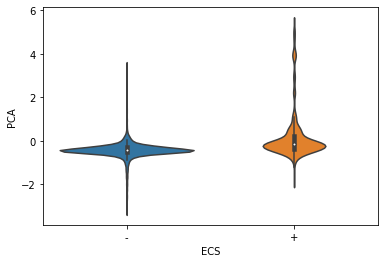

In [254]:
sns.violinplot(x = "ECS", y = "PCA", data = df.reset_index())

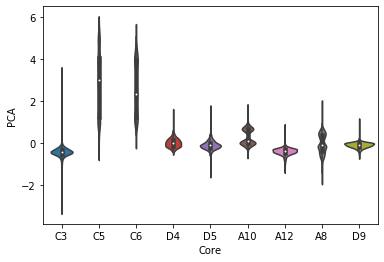

In [267]:
sns.violinplot(x = "Core", y = "PCA", data = df.reset_index())

In [251]:
df

898       902       906       910       914       917  \
Core ECS                                                               
C3   -    0.214312  0.191091  0.195508  0.222698  0.231200  0.222930   
     -    0.231992  0.219790  0.199261  0.206174  0.224913  0.234315   
     -    0.198140  0.202776  0.185451  0.158884  0.145301  0.154051   
     -    0.138318  0.148427  0.168654  0.161829  0.155318  0.172147   
     -    0.087075  0.094139  0.108012  0.111501  0.116876  0.133214   
...            ...       ...       ...       ...       ...       ...   
D9   +    0.091681  0.089567  0.101908  0.111067  0.095253  0.081963   
     +    0.113727  0.117949  0.123123  0.113805  0.084018  0.057816   
     +    0.095951  0.097044  0.088089  0.082563  0.075474  0.065201   
     +    0.081692  0.072478  0.082772  0.099519  0.093358  0.077109   
     +    0.049121  0.037671  0.044262  0.052166  0.053024  0.055671   

               921       925       929       933  ...      3772      3775  \
Core ECS                                          ...                       
C3   -    0.211314  0.197655  0.197759  0.211244  ...  0.242982  0.243633   
     -    0.231984  0.221773  0.210387  0.204696  ...  0.257018  0.255679   
     -    0.164455  0.166549  0.165936  0.163834  ...  0.192957  0.193938   
     -    0.189362  0.194212  0.192112  0.191235  ...  0.207530  0.209197   
     -    0.140019  0.141190  0.145396  0.143244  ...  0.186340  0.186710   
...            ...       ...       ...       ...  ...       ...       ...   
D9   +    0.087309  0.089087  0.083139  0.078411  ...  0.105247  0.107069   
     +    0.066959  0.084429  0.082754  0.076709  ...  0.123739  0.124117   
     +    0.063147  0.063167  0.063177  0.065310  ...  0.103603  0.103143   
     +    0.076711  0.078603  0.076610  0.074464  ...  0.114923  0.115785   
     +    0.059071  0.058857  0.053983  0.049091  ...  0.138518  0.139365   

              3779      3783      3787      3791      3795      3799  \
Core ECS                                                               
C3   -    0.245073  0.246401  0.246972  0.247871  0.247577  0.245361   
     -    0.255497  0.258117  0.260129  0.259935  0.258687  0.256440   
     -    0.193731  0.193813  0.194842  0.195037  0.193313  0.191167   
     -    0.208695  0.207203  0.206663  0.207208  0.207628  0.207940   
     -    0.186410  0.185574  0.185191  0.185126  0.184274  0.182857   
...            ...       ...       ...       ...       ...       ...   
D9   +    0.108130  0.107293  0.106515  0.106191  0.106191  0.105780   
     +    0.125685  0.125629  0.123793  0.123279  0.124585  0.125081   
     +    0.102709  0.102732  0.103225  0.103697  0.105455  0.105813   
     +    0.115346  0.115493  0.116627  0.116754  0.115513  0.113199   
     +    0.139525  0.139209  0.138770  0.138523  0.139243  0.139000   

              3802       PCA  
Core ECS                      
C3   -    0.243958 -1.656505  
     -    0.255024 -1.993397  
     -    0.191225 -2.012943  
     -    0.208320 -1.670712  
     -    0.182712 -1.131638  
...            ...       ...  
D9   +    0.105346 -0.214964  
     +    0.125860 -0.163717  
     +    0.103932 -0.137875  
     +    0.112809 -0.173607  
     +    0.138179 -0.438516  

[33243 rows x 755 columns]

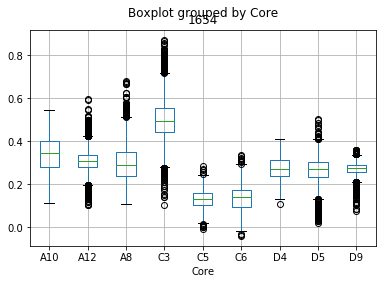

In [246]:
df.boxplot(column = "1654", by = "Core")

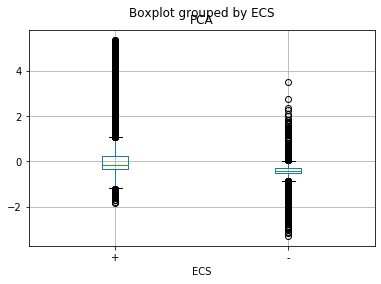

In [243]:
df.boxplot(column = "PCA", by = "ECS")

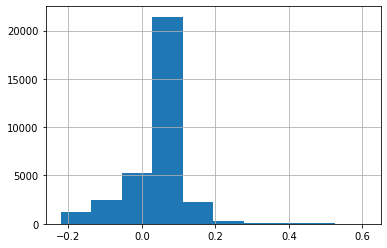

In [176]:
total.iloc[:, 340].hist()

In [164]:
for name, df in total.iloc[:, 340].groupby(["Core","ECS"]):
    
    print(name)
    plt.hist(df, label = name.join(), density = True, histtype = "step")
    
    
plt.legend()

('A10', '+')


AttributeError: 'tuple' object has no attribute 'join'

In [171]:
vars(total.groupby(["Core","ECS"]))

{'_selection': None,
 'level': None,
 'as_index': True,
 'keys': ['Core', 'ECS'],
 'sort': True,
 'group_keys': True,
 'squeeze': False,
 'observed': False,
 'mutated': False,
 'obj':                898       902       906       910       914       917  \
 Core ECS                                                               
 C3   -    0.214312  0.191091  0.195508  0.222698  0.231200  0.222930   
      -    0.231992  0.219790  0.199261  0.206174  0.224913  0.234315   
      -    0.198140  0.202776  0.185451  0.158884  0.145301  0.154051   
      -    0.138318  0.148427  0.168654  0.161829  0.155318  0.172147   
      -    0.087075  0.094139  0.108012  0.111501  0.116876  0.133214   
 ...            ...       ...       ...       ...       ...       ...   
 D9   +    0.091681  0.089567  0.101908  0.111067  0.095253  0.081963   
      +    0.113727  0.117949  0.123123  0.113805  0.084018  0.057816   
      +    0.095951  0.097044  0.088089  0.082563  0.075474  0.065201   
      +    0.0

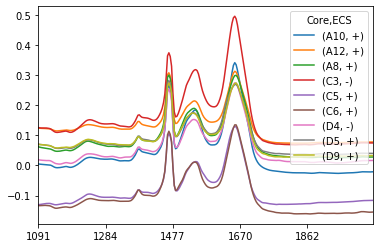

In [147]:
total.groupby(["Core","ECS"]).mean().iloc[:,50:300].T.plot()

In [106]:
df.head()

,898,902,906,910,914,917,921,925,929,933,...,3772,3775,3779,3783,3787,3791,3795,3799,3802,Core
0,0.099558,0.080367,0.069475,0.063485,0.065029,0.069445,0.067829,0.060108,0.060670,0.066084,...,0.097237,0.097934,0.097241,0.096624,0.097098,0.097204,0.096254,0.095176,0.095564,D5
1,0.063717,0.072751,0.073545,0.055414,0.042897,0.046959,0.051137,0.053427,0.058886,0.065400,...,0.095243,0.096804,0.097881,0.097972,0.097284,0.096857,0.096758,0.096554,0.096985,D5
2,0.083198,0.053353,0.039079,0.040018,0.050468,0.066133,0.075706,0.073112,0.065596,0.061614,...,0.093673,0.093807,0.093683,0.094015,0.093375,0.092550,0.092749,0.094048,0.094963,D5
3,0.055584,0.036954,0.043414,0.051225,0.059772,0.066574,0.067892,0.067810,0.064942,0.059484,...,0.101022,0.101698,0.101421,0.100435,0.099569,0.100377,0.101573,0.100962,0.099881,D5
4,0.039360,0.032404,0.032477,0.041355,0.042015,0.039970,0.044137,0.051773,0.055019,0.055190,...,0.109326,0.109297,0.109450,0.109176,0.109927,0.110543,0.110166,0.110571,0.111636,D5


In [78]:
im = datacube.load()

In [99]:
df = pd.DataFrame(im[mask, : ])

In [71]:
test = pd.DataFrame(classes)

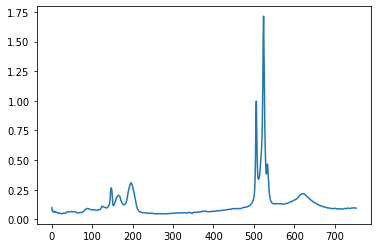

In [77]:
plt.plot(test[0][0])

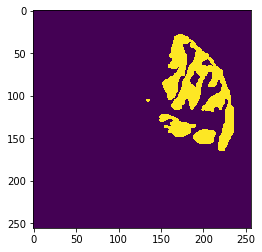

In [35]:
plt.imshow(np.all(annotation == [255,127,39,255], axis = 2))

[255 127  39 255]


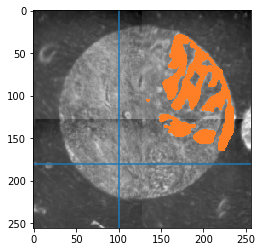

In [34]:
x, y = 180,100

plt.imshow(annotation)
plt.axvline(y)
plt.axhline(x)

print(annotation[y,x,:])